In [3]:
!/opt/bin/nvidia-smi

Wed Jun  9 06:55:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision.models as models

In [6]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


In [7]:
if not os.path.exists('./hotdog_nothotdog'):
  #import gdown
  #url = 'https://drive.google.com/uc?id=1hwyBl4Fa0IHihun29ahszf1M2cxn9TFk'
  #gdown.download(url, './hotdog_nothotdog.zip', quiet=False)
  !wget https://people.compute.dtu.dk/mohan/02514/hotdog_nothotdog.zip
  !unzip ./hotdog_nothotdog.zip > /dev/null

--2021-06-09 06:56:27--  https://people.compute.dtu.dk/mohan/02514/hotdog_nothotdog.zip
Resolving people.compute.dtu.dk (people.compute.dtu.dk)... 130.225.68.6
Connecting to people.compute.dtu.dk (people.compute.dtu.dk)|130.225.68.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 271143160 (259M) [application/zip]
Saving to: ‘hotdog_nothotdog.zip’

hotdog_nothotdog.zi 100%[===================>] 258.58M  10.4MB/s    in 36s     

2021-06-09 06:57:04 (7.13 MB/s) - ‘hotdog_nothotdog.zip’ saved [271143160/271143160]



In [8]:
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='hotdog_nothotdog'):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        
        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y

In [10]:
size = 128
train_transform = transforms.Compose([transforms.RandomRotation(45), transforms.RandomHorizontalFlip(), transforms.Resize((size, size)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
test_transform = transforms.Compose([transforms.Resize((size, size)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

batch_size = 64
trainset = Hotdog_NotHotdog(train=True, transform=train_transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
testset = Hotdog_NotHotdog(train=False, transform=test_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integ

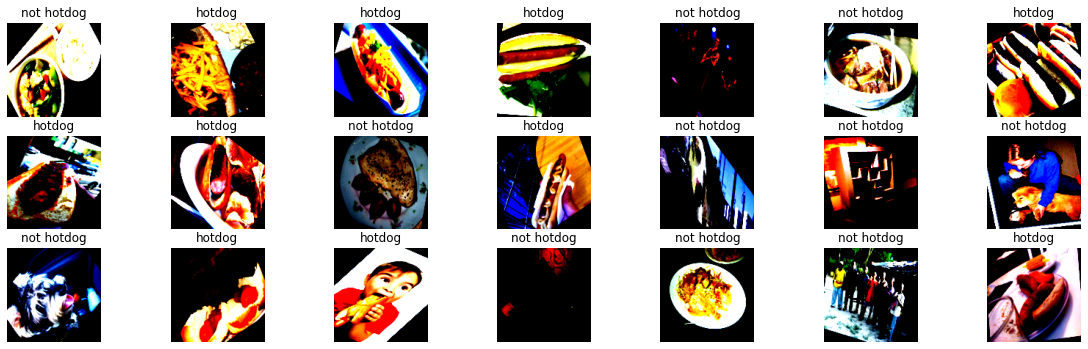

In [11]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))
images.shape
for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    plt.title(['hotdog', 'not hotdog'][labels[i].item()])
    plt.axis('off')


In [12]:
model = models.resnet18(pretrained = True)
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs,2)
model.to(device)
criterion = nn.CrossEntropyLoss()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [13]:
#Initialize the optimizer
optimizer1 = torch.optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)
optimizer2 = torch.optim.Adam(model.fc.parameters(), lr=0.00001)

In [14]:
#We define the training as a function so we can easily re-use it.
def train(model, optimizer, num_epochs=10):
    #  def loss_fun(output, target):
    #     return F.nll_loss(torch.log(output), target)
    out_dict = {'train_acc': [],
              'test_acc': [],
              'train_loss': [],
              'test_loss': []}
  
    for epoch in tqdm(range(num_epochs), unit='epoch'):
        model.train()
        #For each epoch
        train_correct = 0
        train_loss = []
        for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data, target = data.to(device), target.to(device)
            #Zero the gradients computed for each weight
            optimizer.zero_grad()
            #Forward pass your image through the network
            output = model(data)
            #Compute the loss
            loss = criterion(output, target)
            #Backward pass through the network
            loss.backward()
            #Update the weights
            optimizer.step()

            train_loss.append(loss.item())
            #Compute how many were correctly classified
            predicted = output.argmax(1)
            train_correct += (target==predicted).sum().cpu().item()
        #Comput the test accuracy
        test_loss = []
        test_correct = 0
        model.eval()
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            with torch.no_grad():
                output = model(data)
            test_loss.append(criterion(output, target).cpu().item())
            predicted = output.argmax(1)
            test_correct += (target==predicted).sum().cpu().item()
        out_dict['train_acc'].append(train_correct/len(trainset))
        out_dict['test_acc'].append(test_correct/len(testset))
        out_dict['train_loss'].append(np.mean(train_loss))
        out_dict['test_loss'].append(np.mean(test_loss))
        print(f"Loss train: {np.mean(train_loss):.3f}\t test: {np.mean(test_loss):.3f}\t",
              f"Accuracy train: {out_dict['train_acc'][-1]*100:.1f}%\t test: {out_dict['test_acc'][-1]*100:.1f}%")
    return out_dict

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Loss train: 0.530	 test: 0.397	 Accuracy train: 73.5%	 test: 81.6%



Loss train: 0.363	 test: 0.380	 Accuracy train: 84.9%	 test: 84.4%



Loss train: 0.336	 test: 0.347	 Accuracy train: 86.2%	 test: 85.0%



Loss train: 0.306	 test: 0.335	 Accuracy train: 87.6%	 test: 85.4%



Loss train: 0.305	 test: 0.320	 Accuracy train: 86.6%	 test: 87.4%



Loss train: 0.296	 test: 0.315	 Accuracy train: 87.6%	 test: 86.4%



Loss train: 0.289	 test: 0.310	 Accuracy train: 88.4%	 test: 87.5%



Loss train: 0.287	 test: 0.308	 Accuracy train: 88.4%	 test: 87.6%



Loss train: 0.291	 test: 0.302	 Accuracy train: 87.7%	 test: 87.9%



Loss train: 0.276	 test: 0.303	 Accuracy train: 88.5%	 test: 88.0%




Loss train: 0.279	 test: 0.303	 Accuracy train: 88.6%	 test: 87.6%



Loss train: 0.272	 test: 0.302	 Accuracy train: 88.9%	 test: 87.8%



Loss train: 0.261	 test: 0.301	 Accuracy train: 89.9%	 test: 87.9%



Loss train: 0.268	 test: 0.301	 Accuracy train: 88.6%	 test: 87.5%



Loss train: 0.269	 test: 0.302	 Accuracy train: 88.9%	 test: 87.5%



Loss train: 0.276	 test: 0.301	 Accuracy train: 89.4%	 test: 87.8%



Loss train: 0.259	 test: 0.302	 Accuracy train: 89.7%	 test: 87.6%



Loss train: 0.271	 test: 0.302	 Accuracy train: 89.1%	 test: 87.8%



Loss train: 0.261	 test: 0.299	 Accuracy train: 89.6%	 test: 87.8%



Loss train: 0.268	 test: 0.301	 Accuracy train: 89.0%	 test: 88.1%



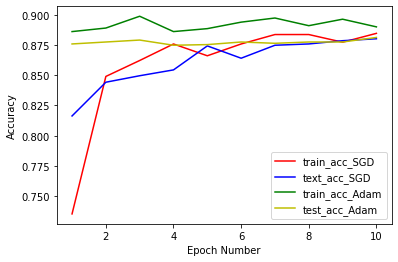

In [15]:
out_dict1 = train(model, optimizer1)
out_dict2 = train(model, optimizer2)
x = [1,2,3,4,5,6,7,8,9,10]
y1 = out_dict1["train_acc"]
y2 = out_dict1["test_acc"]
y3 = out_dict2["train_acc"]
y4 = out_dict2["test_acc"]
plt.plot(x, y1, "r")
plt.plot(x, y2, "b")
plt.plot(x, y3, "g")
plt.plot(x, y4, "y")
plt.legend(("train_acc_SGD", "text_acc_SGD", "train_acc_Adam", "test_acc_Adam"))
plt.xlabel("Epoch Number")
plt.ylabel("Accuracy")
plt.show()